# Projeto de Classificação para Marinha do Brasil

## Autor: Natanael Junior (natmourajr@gmail.com)

Laboratório de Processamento de Sinais - UFRJ

Laboratório de Tecnologia Sonar

Instituto de Pesquisas da Marinha - IPqM

# Bibliotecas e leitura dos dados
As bibliotecas necessárias para a inclusão

In [1]:
import os
import pickle
import numpy as np
import time

from sklearn.decomposition import PCA
from sklearn.externals import joblib

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

analysis_name = 'PCASingleClassSVM'
data_path = os.getenv('OUTPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')

pict_results_path = results_path+'/'+analysis_name+'/picts'
files_results_path = results_path+'/'+analysis_name+'/output_files'

# Read data
# Check if LofarData has created...
m_time = time.time()

database = '4classes'
n_pts_fft = 1024
decimation_rate = 3
spectrum_bins_left = 400
development_flag = True
development_events = 101

if not os.path.exists('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                      (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left)):
    print 'No Files in %s/%s\n'%(data_path,database)
else:
    #Read lofar data
    [data,trgt,class_labels] = joblib.load('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                                           (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left))


    m_time = time.time()-m_time
    print 'Time to read data file: '+str(m_time)+' seconds'

    # correct format
    all_data = data
    all_trgt = trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))
    
    # Process data
    # unbalanced data to balanced data with random data creation of small classes

    # Same number of events in each class
    qtd_events_biggest_class = 0
    biggest_class_label = ''

    for iclass, class_label in enumerate(class_labels):
        if sum(all_trgt==iclass) > qtd_events_biggest_class:
            qtd_events_biggest_class = sum(all_trgt==iclass)
            biggest_class_label = class_label
        print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
    print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)


    balanced_data = {}
    balanced_trgt = {}

    from Functions import DataHandler as dh
    m_datahandler = dh.DataHandlerFunctions()

    for iclass, class_label in enumerate(class_labels):
        if development_flag:
            class_events = all_data[all_trgt==iclass,:]
            if len(balanced_data) == 0:
                balanced_data = class_events[0:development_events,:]
                balanced_trgt = (iclass)*np.ones(development_events)
            else:
                balanced_data = np.append(balanced_data,
                                          class_events[0:development_events,:], 
                                          axis=0)
                balanced_trgt = np.append(balanced_trgt,(iclass)*np.ones(development_events))
        else:
            if len(balanced_data) == 0:
                class_events = all_data[all_trgt==iclass,:]
                balanced_data = m_datahandler.CreateEventsForClass(
                    class_events,qtd_events_biggest_class-(len(class_events)))
                balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
            else:
                class_events = all_data[all_trgt==iclass,:]
                created_events = (m_datahandler.CreateEventsForClass(all_data[all_trgt==iclass,:],
                                                                     qtd_events_biggest_class-
                                                                     (len(class_events))))
                balanced_data = np.append(balanced_data,created_events,axis=0)
                balanced_trgt = np.append(balanced_trgt,
                                          (iclass)*np.ones(created_events.shape[0]),axis=0)
        
    all_data = balanced_data
    all_trgt = balanced_trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))

Time to import all libraries: 5.50746917725e-05 seconds
Time to read data file: 4.45745301247 seconds


Using TensorFlow backend.


Qtd event of 0 is 12939
Qtd event of 1 is 29352
Qtd event of 2 is 11510
Qtd event of 3 is 23760

Biggest class is 1 with 29352 events


In [2]:
from Functions import LogFunctions as log

# Create a entry in log file
m_log = log.LogInformation()
#date = m_log.CreateLogEntry("NoveltyDetection",'PCASingleClassSVM')
log_entries = m_log.RecoverLogEntries(package_name="NoveltyDetection")
print log_entries

{0: {'date': '2017_07_07_19_58_38', 'package': 'PCASingleClassSVM'}}


SVMNoveltyDetection analysis nu sweep function


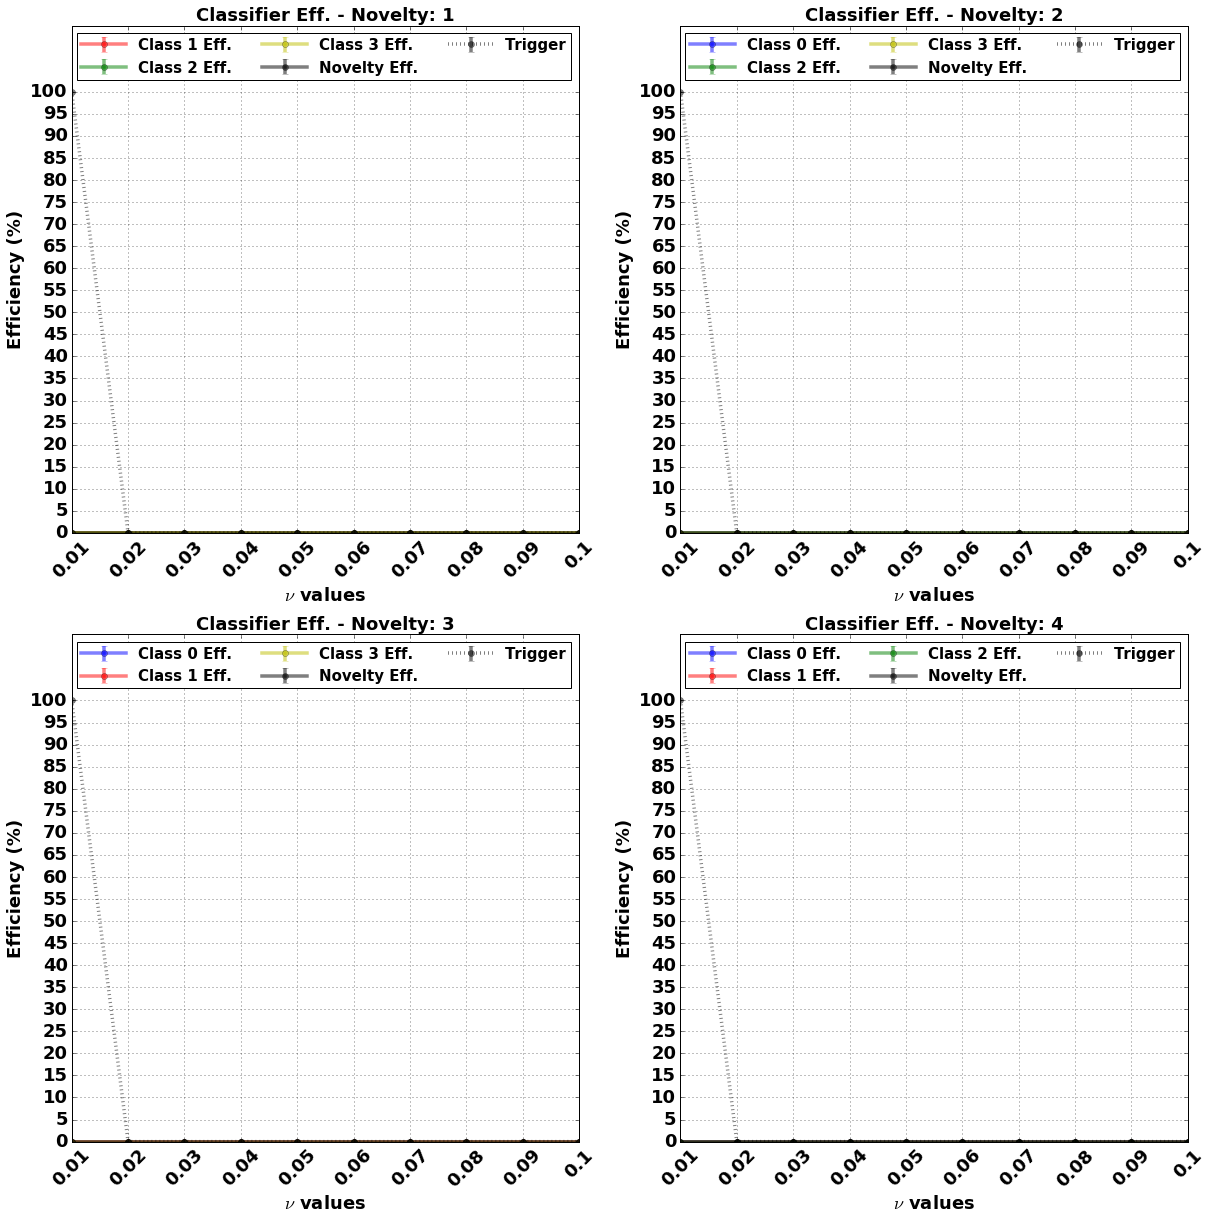

In [10]:
from Functions import NoveltyDetectionAnalysis as novelty_detection
obj = novelty_detection.SVMNoveltyDetection(name=analysis_name,
                                           preproc_path=files_results_path,
                                           train_path=files_results_path,
                                           anal_path=files_results_path)
date = '2017_07_07_19_58_38'
obj.trn_info = novelty_detection.TrnInformation(date=date, n_folds=4)
obj.trn_info.SplitTrainSet(all_trgt)

#obj.trn_info.Print()

#[data_proc, trgt_proc] = obj.preprocess(all_data,trgt_sparse,novelty_class=0,trn_info=obj.trn_info,fold=0)
#svm_obj = obj.train(all_data,trgt_sparse, novelty_class=3, nu_value=0.1, trn_info=obj.trn_info, fold=0)

#obj.analysis_output_hist(all_data, trgt_sparse, trn_info=obj.trn_info, nu_value=0.01, fold=1)
obj.analysis_nu_sweep(all_data, trgt_sparse, obj.trn_info, min_nu=0.01, max_nu=0.1, nu_step=0.01)